In [1]:
# importing the libraries  and configuring the modules 

import os 

img_dir = 'data/'

import matplotlib.pyplot as plt 
import matplotlib as mpl 

mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time 
import functools 

In [2]:
# Importing tensorflow 

import tensorflow as tf 

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

Enabling eager-execution. Eager execution allows us to work through this technique in clearest and most readable way

In [4]:

print("Eager Execution: {}".format(tf.executing_eagerly()))

Eager Execution: True


In [5]:
# setting up the image paths 
content_path = img_dir +'content/content_8.jpg'
style_path = img_dir + 'style/style_8.jpg'

Visualizing the input 

In [6]:
def load_img(path_to_img):
    max_dim = 512 
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    
    img = kp_image.img_to_array(img)
    
    # we need to broadcast the image array such that it has a batch dimension
    
    img = np.expand_dims(img, axis=0)
    return img 

In [7]:
def imshow(img, title=None):
    # Remove the batch dimension
    out = np.squeeze(img, axis=0)
    # Normalize for display
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.imshow(out)

These are input content and style images. We hope to 'create' an image with the content of our content image, but with the sytle of the style image 

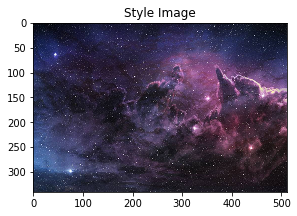

In [8]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

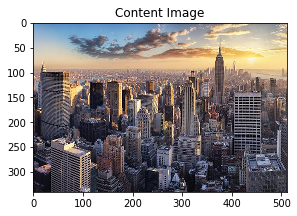

In [9]:
plt.subplot(1,2,2)
imshow(content, 'Content Image')
plt.show()

## Prepare the data 

Let's create methods that will allow us to load and preprocess our image easily. We perform the same preprocessing process as are expected according to the VGG training process. VGG networks are trained on image with each channel 
normalized by mean = [103.939, 116.779, 123.68] and with channels BGR 

In [10]:
def load_and_preprocess_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img 

In order to view the outputs of our optimization, we are required to perform the inverse preprocessing step. Furthermore since our optimized image may take it values anywhere infinity and -infinity, we must clip to maintain our values from within the 0-255 range 

In [11]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
    
    # Perform the inverse of the preprocessing step 
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x
    

## Defining content and style representations 

In [12]:
# content layer where will pill our feature maps 
content_layers = ['block_conv2']

# Style layers we are interested in 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model 

In the case, we load the VGG19 and feed our input tensor to the model. This will allow us to extract the feature maps. 


In [16]:
def get_model():
    """
    Creates our model with access to intermediate layers.
    
    This function will load the VGG19 model and access the intermediate layers. 
    These laers will then be used to create a new model that will take input image 
    and return the outputs from these intermediate layers from the VG model.
    
    Returns:
        return a keras model that takes image inputs and outputs the style and content 
        intermediate layers 
    """
    # Load our model. we load pretrained VGG, trained on imagenet data 
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False 
    # Get ouput layers corresponding ot style and content layers 
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs+content_outputs
    # Build Model
    return models.Model(vgg.input, model_outputs)

## Define and create our loss functions (content and style distances)